<a href="https://colab.research.google.com/github/lilu313/MSBD5001-Fall2018/blob/master/LinearRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import math
from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn.feature_selection import VarianceThreshold, RFE
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error

In [2]:
# please upload train.csv and test.csv to google drive first
# mounting google drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


TRAIN SET

In [0]:
train = pd.read_csv('/content/gdrive/My Drive/train.csv', index_col=0)

In [4]:
train['n_jobs'].replace({-1:16}, inplace=True)

# transform the nominal feature 'penalty' into one hot vector
train['penalty'].replace({'none':0, 'l1':1, 'elasticnet':2, 'l2':3}, inplace=True)
n_feature = []
for i in range(len(train)):
  n_feature.append([train.iloc[i]['penalty']])
enc = preprocessing.OneHotEncoder(sparse=False)
n_feature = enc.fit_transform(n_feature).tolist()
for i in range(len(train)):
  for j in range(4):
    train.loc[i, j] = n_feature[i][j]
train.pop('penalty')


# split the features and the target
# also take log of 'time' because of its skewed distribution
y_train = train['time'].tolist()
log_y_train = []
for i in range(len(y_train)):
  log_y_train.append(math.log(y_train[i]+1))
train.pop('time')

train.pop('random_state')

train.head()

,l1_ratio,alpha,max_iter,n_jobs,n_samples,n_features,n_classes,n_clusters_per_class,n_informative,flip_y,scale,0,1,2,3
id,,,,,,,,,,,,,,,
0,0.304083,0.0001,417,16,1089,327,4,3,7,0.074798,24.242009,1.0,0.0,0.0,0.0
1,0.727744,0.0010,578,1,790,373,4,5,7,0.077781,54.626302,0.0,1.0,0.0,0.0
2,0.745885,0.0100,588,2,428,1198,2,5,6,0.030196,17.999964,1.0,0.0,0.0,0.0
3,0.474605,0.0010,829,4,877,313,6,5,7,0.057261,82.257222,1.0,0.0,0.0,0.0
4,0.395049,0.0010,167,2,216,644,8,5,11,0.073728,95.515601,0.0,0.0,1.0,0.0


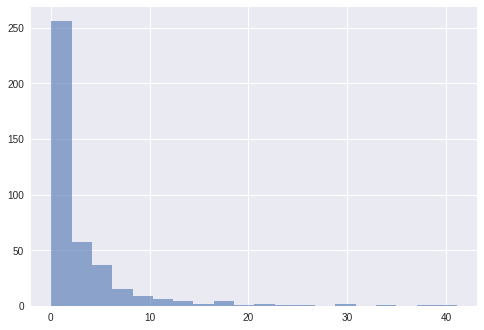

In [5]:
# plot the distribution of 'time'
fig,ax=plt.subplots()
ax.hist(y_train,bins=20,histtype="stepfilled",alpha=0.6)
plt.show()

In [6]:
train.shape

(400, 15)

In [7]:
X_train = []
for i in range(len(train)):
  X_train.append(train.iloc[i].tolist())
print(len(X_train))
print(len(X_train[0]))

400
15


In [0]:
scaler = preprocessing.MinMaxScaler().fit(np.array(X_train))
X_train = scaler.transform(np.array(X_train))

In [9]:
poly = preprocessing.PolynomialFeatures().fit(X_train)
X_train = poly.transform(X_train)
X_train.shape

(400, 136)

In [10]:
var = VarianceThreshold(threshold=0.05).fit(X_train)
X_train_select = var.transform(X_train)
X_train_select.shape

(400, 113)

In [11]:
rfe = RFE(estimator=LinearRegression(), n_features_to_select=50).fit(X_train_select, log_y_train)
X_train_select = rfe.transform(X_train_select)
X_train_select.shape

(400, 50)

In [12]:
pca = PCA(n_components=0.9999).fit(X_train_select)
X_train_select = pca.transform(X_train_select)
X_train_select.shape

(400, 44)

TEST SET

In [0]:
test = pd.read_csv('/content/gdrive/My Drive/test.csv', index_col=0)

In [14]:
test['n_jobs'].replace({-1:16}, inplace=True)
test['penalty'].replace({'none':0, 'l1':1, 'elasticnet':2, 'l2':3}, inplace=True)

n_feature = []
for i in range(len(test)):
  n_feature.append([test.iloc[i]['penalty']])
enc = preprocessing.OneHotEncoder(sparse=False)
n_feature = enc.fit_transform(n_feature).tolist()
for i in range(len(test)):
  for j in range(4):
    test.loc[i, j] = n_feature[i][j]
test.pop('penalty')
test.pop('random_state')

test.head()

,l1_ratio,alpha,max_iter,n_jobs,n_samples,n_features,n_classes,n_clusters_per_class,n_informative,flip_y,scale,0,1,2,3
id,,,,,,,,,,,,,,,
0,0.690384,0.001,602,4,1376,1078,3,4,8,0.049072,40.832757,0.0,0.0,0.0,1.0
1,0.215088,0.001,522,4,598,1528,10,3,11,0.041393,68.611537,0.0,0.0,1.0,0.0
2,0.217458,0.001,398,16,553,1008,8,5,8,0.005987,61.713892,0.0,0.0,0.0,1.0
3,0.120303,0.001,439,16,1977,1319,3,4,10,0.002964,58.631194,1.0,0.0,0.0,0.0
4,0.458851,0.010,278,4,1826,1530,7,5,8,0.050126,87.315374,1.0,0.0,0.0,0.0


In [15]:
test.shape

(100, 15)

In [16]:
X_test = []
for i in range(len(test)):
  X_test.append(test.iloc[i].tolist())
print(len(X_test))
print(len(X_test[0]))

100
15


In [0]:
X_test = scaler.transform(np.array(X_test))

In [18]:
X_test = poly.transform(X_test)
X_test.shape

(100, 136)

In [19]:
X_test_select = var.transform(X_test)
X_test_select.shape

(100, 113)

In [20]:
X_test_select = rfe.transform(X_test_select)
X_test_select.shape

(100, 50)

In [21]:
X_test_select = pca.transform(X_test_select)
X_test_select.shape

(100, 44)

Linear Regression

In [0]:
lr = LinearRegression()

In [0]:
predict = cross_val_predict(lr, X_train_select, log_y_train, cv=10)

In [0]:
for i in range(len(predict)):
  predict[i] = math.exp(predict[i]) - 1
  if (predict[i]<0):
    predict[i] = 0

In [25]:
mean_squared_error(y_train, predict)

2.6532479509931424

In [0]:
lr = LinearRegression().fit(X_train_select, log_y_train)

In [0]:
result = lr.predict(X_test_select)

In [0]:
for i in range(len(result)):
  result[i] = math.exp(result[i]) - 1

In [0]:
df = pd.DataFrame(columns=['Id', 'time'])

In [0]:
for i in range(len(result)):
  df.loc[i, 'Id'] = i
  if(result[i]>=0):
    df.loc[i, 'time'] = result[i]
  else:
    df.loc[i, 'time'] = 0

In [31]:
df.head()

,Id,time
0,0,1.06086
1,1,12.1109
2,2,0.436049
3,3,0.0612582
4,4,1.70094


In [0]:
df.to_csv("/content/gdrive/My Drive/competition/data/submission.csv", index = False)